### Import Library

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import plotly.express as px
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import MinMaxScaler 

import tensorflow as tf

import numpy as np
import pandas as pd
import math

from sklearn.metrics import mean_squared_error as mse
from keras.losses import MeanAbsolutePercentageError

from keras.initializers import RandomUniform

# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')

### Import Dataset

In [2]:
df = pd.read_csv('data/data_vitb.csv')

### EDA

In [3]:
# Convert Dataset into DataFrame
# dataset = pd.DataFrame(dataset)
df.head()

,Month,Use_VitBComplex
0,2015-01-01,2457
1,2015-02-01,2356
2,2015-03-01,2437
3,2015-04-01,2512
4,2015-05-01,2345


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Month            84 non-null     object
 1   Use_VitBComplex  84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [5]:
df.isna().sum()

Month              0
Use_VitBComplex    0
dtype: int64

In [6]:
df.describe()

,Use_VitBComplex
count,84.000000
mean,2469.380952
std,113.577626
min,2234.000000
25%,2363.250000
50%,2455.000000
75%,2561.750000
max,2732.000000


In [7]:
df['Month'] = pd.to_datetime(df['Month']).dt.date
df.head()

,Month,Use_VitBComplex
0,2015-01-01,2457
1,2015-02-01,2356
2,2015-03-01,2437
3,2015-04-01,2512
4,2015-05-01,2345


In [8]:
plot = px.line(df, x=df.Month, y=df.Use_VitBComplex)
plot.show()

In [9]:
plot = px.histogram(df, x=df.Use_VitBComplex, marginal='box')
plot.show()

### Data Preprocessing

In [10]:
df['Month'] = pd.to_datetime(df['Month']).dt.to_period('M')

In [11]:
df.set_index('Month', inplace=True)
df.head()

,Use_VitBComplex
Month,
2015-01,2457
2015-02,2356
2015-03,2437
2015-04,2512
2015-05,2345


In [12]:
df = df.values

In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)
df

array([[0.44779116],
       [0.24497992],
       [0.40763052],
       [0.55823293],
       [0.22289157],
       [0.29518072],
       [0.60441767],
       [0.47188755],
       [0.84337349],
       [0.40361446],
       [0.82128514],
       [0.44578313],
       [0.23092369],
       [0.35542169],
       [0.42168675],
       [0.46385542],
       [0.8253012 ],
       [0.937751  ],
       [0.6686747 ],
       [0.2248996 ],
       [0.08835341],
       [0.26506024],
       [0.36947791],
       [0.47188755],
       [0.82128514],
       [0.39558233],
       [0.2188755 ],
       [0.41967871],
       [0.55823293],
       [0.41164659],
       [0.40562249],
       [0.35542169],
       [0.89156627],
       [0.6686747 ],
       [0.1746988 ],
       [0.41767068],
       [0.62048193],
       [0.47791165],
       [0.22891566],
       [0.66465863],
       [0.67269076],
       [0.24497992],
       [0.46787149],
       [0.39156627],
       [0.65662651],
       [0.52008032],
       [0.6626506 ],
       [0.483

In [14]:
train_size = int(len(df) * 0.8)
test_size = (len(df)) - train_size
print(train_size, test_size)

67 17


In [15]:
train , test = df[0:train_size,:] , df[train_size:len(df),:]

In [16]:
def to_sequences(df, seq_size):
    x = []
    y = []

    for i in range(len(df)-seq_size):
        window = df[i:(i+seq_size), 0]
        x.append(window)
        y.append(df[i+seq_size, 0])

    return np.array(x), np.array(y)

In [17]:
seq_size = 5

trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)

print("Shape of training set: {}".format(trainX.shape))
print("Shape of testinf set: {}".format(testX.shape))

Shape of training set: (62, 5)
Shape of testinf set: (12, 5)


In [18]:
mape = MeanAbsolutePercentageError()

### Model 1

In [19]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(6, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model1.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model1.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=50, batch_size=6)

model1.evaluate(testX, testY)


1/1 [==============================] - 0s 152ms/step - loss: 0.0528 - mean_absolute_error: 0.1963


[0.052843134850263596, 0.1962658017873764]

In [20]:
trainPredict1 = model1.predict(trainX)
testPredict1 = model1.predict(testX)

trainPredict1 = scaler.inverse_transform(trainPredict1)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict1 = scaler.inverse_transform(testPredict1)
testY_inverse = scaler.inverse_transform([testY])

print('Model 1')

trainScore1 = math.sqrt(mse(trainY_inverse[0], trainPredict1[:,0]))
print('Train score: %.2f' % (trainScore1))

testScore1 = math.sqrt(mse(testY_inverse[0], testPredict1[:,0]))
print('Test score: %.2f' % (testScore1))

1/1 [==============================] - 0s 33ms/step
Model 1
Train score: 100.27
Test score: 114.48


In [21]:
mapeTrain1 = mape(trainY_inverse, trainPredict1)
print('MAPE Train   :  ', mapeTrain1.numpy())
print('Akurasi Train: ', 100 - (mapeTrain1.numpy()))

mape1 = mape(testY_inverse, testPredict1)
print('MAPE Test    :  ', mape1.numpy())
print('Akurasi Test : ', 100 - (mape1.numpy()))

MAPE Train   :   4.2594495
Akurasi Train:  95.74055051803589
MAPE Test    :   4.0746913
Akurasi Test :  95.92530870437622


### Model 2

In [22]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(6, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model2.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model2.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=100, batch_size=6)

model2.evaluate(testX, testY)


1/1 [==============================] - 0s 126ms/step - loss: 0.0530 - mean_absolute_error: 0.2004


[0.05303938686847687, 0.20040221512317657]

In [23]:
trainPredict2 = model2.predict(trainX)
testPredict2 = model2.predict(testX)

trainPredict2 = scaler.inverse_transform(trainPredict2)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict2 = scaler.inverse_transform(testPredict2)
testY_inverse = scaler.inverse_transform([testY])

print('Model 2')

trainScore2 = math.sqrt(mse(trainY_inverse[0], trainPredict2[:,0]))
print('Train score: %.2f' % (trainScore2))

testScore2 = math.sqrt(mse(testY_inverse[0], testPredict2[:,0]))
print('Test score: %.2f' % (testScore2))

1/1 [==============================] - 0s 28ms/step
Model 2
Train score: 98.25
Test score: 114.69


In [24]:
mapeTrain2 = mape(trainY_inverse, trainPredict2)
print('MAPE Train: ', mapeTrain2.numpy())
print('Akurasi Train: ', 100 - (mapeTrain2.numpy()))

mape2 = mape(testY_inverse, testPredict2)
print('MAPE Test: ', mape2.numpy())
print('Akurasi Test: ', 100 - (mape2.numpy()))

MAPE Train:  4.2881246
Akurasi Train:  95.71187543869019
MAPE Test:  4.076
Akurasi Test:  95.92399978637695


### Model 3

In [25]:
model3 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(6, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model3.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model3.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=150, batch_size=6)

model3.evaluate(testX, testY)


1/1 [==============================] - 0s 131ms/step - loss: 0.0588 - mean_absolute_error: 0.2028


[0.058847904205322266, 0.2028212547302246]

In [26]:
trainPredict3 = model3.predict(trainX)
testPredict3 = model3.predict(testX)

trainPredict3 = scaler.inverse_transform(trainPredict3)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict3 = scaler.inverse_transform(testPredict3)
testY_inverse = scaler.inverse_transform([testY])

print('Model 3')

trainScore3 = math.sqrt(mse(trainY_inverse[0], trainPredict3[:,0]))
print('Train score: %.2f' % (trainScore3))

testScore3 = math.sqrt(mse(testY_inverse[0], testPredict3[:,0]))
print('Test score: %.2f' % (testScore3))

1/1 [==============================] - 0s 33ms/step
Model 3
Train score: 92.78
Test score: 120.81


In [27]:
mapeTrain3 = mape(trainY_inverse, trainPredict3)
print('MAPE Train: ', mapeTrain3.numpy())
print('Akurasi Train: ', 100 - (mapeTrain3.numpy()))

mape3 = mape(testY_inverse, testPredict3)
print('MAPE Test: ', mape3.numpy())
print('Akurasi Test: ', 100 - (mape3.numpy()))

MAPE Train:  4.438651
Akurasi Train:  95.5613489151001
MAPE Test:  4.363552
Akurasi Test:  95.63644790649414


### Model 4

In [28]:
model4 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(6, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model4.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model4.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=200, batch_size=6)

model4.evaluate(testX, testY)


1/1 [==============================] - 0s 140ms/step - loss: 0.0585 - mean_absolute_error: 0.2070


[0.05849042534828186, 0.20698142051696777]

In [29]:
trainPredict4 = model4.predict(trainX)
testPredict4 = model4.predict(testX)

trainPredict4 = scaler.inverse_transform(trainPredict4)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict4 = scaler.inverse_transform(testPredict4)
testY_inverse = scaler.inverse_transform([testY])

print('Model 4')

trainScore4 = math.sqrt(mse(trainY_inverse[0], trainPredict4[:,0]))
print('Train score: %.2f' % (trainScore4))

testScore4 = math.sqrt(mse(testY_inverse[0], testPredict4[:,0]))
print('Test score: %.2f' % (testScore4))

1/1 [==============================] - 0s 98ms/step
Model 4
Train score: 87.38
Test score: 120.44


In [30]:
mapeTrain4 = mape(trainY_inverse, trainPredict4)
print('MAPE Train: ', mapeTrain4.numpy())
print('Akurasi Train: ', 100 - (mapeTrain4.numpy()))

mape4 = mape(testY_inverse, testPredict4)
print('MAPE Test: ', mape4.numpy())
print('Akurasi Test: ', 100 - (mape4.numpy()))

MAPE Train:  4.506877
Akurasi Train:  95.4931230545044
MAPE Test:  4.2869663
Akurasi Test:  95.71303367614746


### Model 5

In [31]:
model5 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(6, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model5.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model5.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=250, batch_size=6)

model5.evaluate(testX, testY)


1/1 [==============================] - 0s 136ms/step - loss: 0.0843 - mean_absolute_error: 0.2642


[0.08432424068450928, 0.26415562629699707]

In [33]:
trainPredict5 = model5.predict(trainX)
testPredict5 = model5.predict(testX)

trainPredict5 = scaler.inverse_transform(trainPredict5)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict5 = scaler.inverse_transform(testPredict5)
testY_inverse = scaler.inverse_transform([testY])

print('Model 5')

trainScore5 = math.sqrt(mse(trainY_inverse[0], trainPredict5[:,0]))
print('Train score: %.2f' % (trainScore5))

testScore5 = math.sqrt(mse(testY_inverse[0], testPredict5[:,0]))
print('Test score: %.2f' % (testScore5))

1/1 [==============================] - 0s 38ms/step
Model 5
Train score: 89.16
Test score: 144.61


In [34]:
mapeTrain5 = mape(trainY_inverse, trainPredict5)
print('MAPE Train: ', mapeTrain5.numpy())
print('Akurasi Train: ', 100 - (mapeTrain5.numpy()))

mape5 = mape(testY_inverse, testPredict5)
print('MAPE Test: ', mape5.numpy())
print('Akurasi Test: ', 100 - (mape5.numpy()))

MAPE Train:  4.5778227
Akurasi Train:  95.4221773147583
MAPE Test:  4.7090726
Akurasi Test:  95.29092741012573


### Model 6

In [35]:
model6 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(6, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model6.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model6.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=300, batch_size=6)

model6.evaluate(testX, testY)


1/1 [==============================] - 0s 148ms/step - loss: 0.0743 - mean_absolute_error: 0.2308


[0.07431996613740921, 0.23084765672683716]

In [36]:
trainPredict6 = model6.predict(trainX)
testPredict6 = model6.predict(testX)

trainPredict6 = scaler.inverse_transform(trainPredict6)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict6 = scaler.inverse_transform(testPredict6)
testY_inverse = scaler.inverse_transform([testY])

print('Model 6')

trainScore6 = math.sqrt(mse(trainY_inverse[0], trainPredict6[:,0]))
print('Train score: %.2f' % (trainScore6))

testScore6 = math.sqrt(mse(testY_inverse[0], testPredict6[:,0]))
print('Test score: %.2f' % (testScore6))

1/1 [==============================] - 0s 29ms/step
Model 6
Train score: 67.81
Test score: 135.76


In [37]:
mapeTrain6 = mape(trainY_inverse, trainPredict6)
print('MAPE Train: ', mapeTrain6.numpy())
print('Akurasi Train: ', 100 - (mapeTrain6.numpy()))

mape6 = mape(testY_inverse, testPredict6)
print('MAPE Test: ', mape6.numpy())
print('Akurasi Test: ', 100 - (mape6.numpy()))

MAPE Train:  4.838033
Akurasi Train:  95.1619668006897
MAPE Test:  4.3960023
Akurasi Test:  95.60399770736694


### Model 7

In [38]:
model7 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(6, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model7.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model7.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=50, batch_size=8)

model7.evaluate(testX, testY)


1/1 [==============================] - 0s 31ms/step - loss: 0.0493 - mean_absolute_error: 0.1853


[0.04934670031070709, 0.18529093265533447]

In [39]:
trainPredict7 = model7.predict(trainX)
testPredict7 = model7.predict(testX)

trainPredict7 = scaler.inverse_transform(trainPredict7)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict7 = scaler.inverse_transform(testPredict7)
testY_inverse = scaler.inverse_transform([testY])

print('Model 7')

trainScore7 = math.sqrt(mse(trainY_inverse[0], trainPredict7[:,0]))
print('Train score: %.2f' % (trainScore7))

testScore7 = math.sqrt(mse(testY_inverse[0], testPredict7[:,0]))
print('Test score: %.2f' % (testScore7))

1/1 [==============================] - 0s 26ms/step
Model 7
Train score: 104.22
Test score: 110.63


In [40]:
mapeTrain7 = mape(trainY_inverse, trainPredict7)
print('MAPE Train: ', mapeTrain7.numpy())
print('Akurasi Train: ', 100 - (mapeTrain7.numpy()))

mape7 = mape(testY_inverse, testPredict7)
print('MAPE Test: ', mape7.numpy())
print('Akurasi Test: ', 100 - (mape7.numpy()))

MAPE Train:  4.157808
Akurasi Train:  95.84219217300415
MAPE Test:  3.9715128
Akurasi Test:  96.02848720550537


### Model 8

In [41]:
model8 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(6, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model8.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model8.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=100, batch_size=8)

model8.evaluate(testX, testY)


1/1 [==============================] - 0s 30ms/step - loss: 0.0504 - mean_absolute_error: 0.1938


[0.05038386955857277, 0.19382613897323608]

In [42]:
trainPredict8 = model8.predict(trainX)
testPredict8 = model8.predict(testX)

trainPredict8 = scaler.inverse_transform(trainPredict8)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict8 = scaler.inverse_transform(testPredict8)
testY_inverse = scaler.inverse_transform([testY])

print('Model 8')

trainScore8 = math.sqrt(mse(trainY_inverse[0], trainPredict8[:,0]))
print('Train score: %.2f' % (trainScore8))

testScore8 = math.sqrt(mse(testY_inverse[0], testPredict8[:,0]))
print('Test score: %.2f' % (testScore8))

1/1 [==============================] - 0s 99ms/step
Model 8
Train score: 100.49
Test score: 111.78


In [43]:
mapeTrain8 = mape(trainY_inverse, trainPredict8)
print('MAPE Train: ', mapeTrain8.numpy())
print('Akurasi Train: ', 100 - (mapeTrain8.numpy()))

mape8 = mape(testY_inverse, testPredict8)
print('MAPE Test: ', mape8.numpy())
print('Akurasi Test: ', 100 - (mape8.numpy()))

MAPE Train:  4.2279644
Akurasi Train:  95.77203559875488
MAPE Test:  4.0224566
Akurasi Test:  95.97754335403442


### Model 9

In [44]:
model9 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(6, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model9.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model9.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=150, batch_size=8)

model9.evaluate(testX, testY)


1/1 [==============================] - 0s 31ms/step - loss: 0.0564 - mean_absolute_error: 0.2139


[0.056392449885606766, 0.21385347843170166]

In [46]:
trainPredict9 = model9.predict(trainX)
testPredict9 = model9.predict(testX)

trainPredict9 = scaler.inverse_transform(trainPredict9)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict9 = scaler.inverse_transform(testPredict9)
testY_inverse = scaler.inverse_transform([testY])

print('Model 9')

trainScore9 = math.sqrt(mse(trainY_inverse[0], trainPredict9[:,0]))
print('Train score: %.2f' % (trainScore9))

testScore9 = math.sqrt(mse(testY_inverse[0], testPredict9[:,0]))
print('Test score: %.2f' % (testScore9))

1/1 [==============================] - 0s 36ms/step
Model 9
Train score: 97.39
Test score: 118.26


In [47]:
mapeTrain9 = mape(trainY_inverse, trainPredict9)
print('MAPE Train: ', mapeTrain9.numpy())
print('Akurasi Train: ', 100 - (mapeTrain9.numpy()))

mape9 = mape(testY_inverse, testPredict9)
print('MAPE Test: ', mape9.numpy())
print('Akurasi Test: ', 100 - (mape9.numpy()))

MAPE Train:  4.340235
Akurasi Train:  95.65976476669312
MAPE Test:  4.085169
Akurasi Test:  95.91483116149902


### Model 10

In [48]:
model10 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(6, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model10.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model10.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=200, batch_size=8)

model10.evaluate(testX, testY)


1/1 [==============================] - 0s 28ms/step - loss: 0.0566 - mean_absolute_error: 0.2057


[0.05660446360707283, 0.20568831264972687]

In [49]:
trainPredict10 = model10.predict(trainX)
testPredict10 = model10.predict(testX)

trainPredict10 = scaler.inverse_transform(trainPredict10)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict10 = scaler.inverse_transform(testPredict10)
testY_inverse = scaler.inverse_transform([testY])

print('Model 10')

trainScore10 = math.sqrt(mse(trainY_inverse[0], trainPredict10[:,0]))
print('Train score: %.2f' % (trainScore10))

testScore10 = math.sqrt(mse(testY_inverse[0], testPredict10[:,0]))
print('Test score: %.2f' % (testScore10))

1/1 [==============================] - 0s 31ms/step
Model 10
Train score: 91.05
Test score: 118.48


In [50]:
mapeTrain10 = mape(trainY_inverse, trainPredict10)
print('MAPE Train: ', mapeTrain10.numpy())
print('Akurasi Train: ', 100 - (mapeTrain10.numpy()))

mape10 = mape(testY_inverse, testPredict10)
print('MAPE Test: ', mape10.numpy())
print('Akurasi Test: ', 100 - (mape10.numpy()))

MAPE Train:  4.386106
Akurasi Train:  95.61389398574829
MAPE Test:  4.092976
Akurasi Test:  95.90702390670776


### Model 11

In [51]:
model11 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(6, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model11.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model11.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=250, batch_size=8)

model11.evaluate(testX, testY)


1/1 [==============================] - 0s 28ms/step - loss: 0.0693 - mean_absolute_error: 0.2345


[0.06933972239494324, 0.23450595140457153]

In [52]:
trainPredict11 = model11.predict(trainX)
testPredict11 = model11.predict(testX)

trainPredict11 = scaler.inverse_transform(trainPredict11)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict11 = scaler.inverse_transform(testPredict11)
testY_inverse = scaler.inverse_transform([testY])

print('Model 11')

trainScore11 = math.sqrt(mse(trainY_inverse[0], trainPredict11[:,0]))
print('Train score: %.2f' % (trainScore11))

testScore11 = math.sqrt(mse(testY_inverse[0], testPredict11[:,0]))
print('Test score: %.2f' % (testScore11))

1/1 [==============================] - 0s 32ms/step
Model 11
Train score: 76.34
Test score: 131.14


In [53]:
mapeTrain11 = mape(trainY_inverse, trainPredict11)
print('MAPE Train: ', mapeTrain11.numpy())
print('Akurasi Train: ', 100 - (mapeTrain11.numpy()))

mape11 = mape(testY_inverse, testPredict11)
print('MAPE Test: ', mape11.numpy())
print('Akurasi Test: ', 100 - (mape11.numpy()))

MAPE Train:  4.6421266
Akurasi Train:  95.35787343978882
MAPE Test:  4.4303718
Akurasi Test:  95.56962823867798


### Model 12

In [54]:
model12 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(6, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model12.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model12.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=300, batch_size=8)

model12.evaluate(testX, testY)


1/1 [==============================] - 0s 30ms/step - loss: 0.0986 - mean_absolute_error: 0.2509


[0.09855321794748306, 0.25085464119911194]

In [55]:
trainPredict12 = model12.predict(trainX)
testPredict12 = model12.predict(testX)

trainPredict12 = scaler.inverse_transform(trainPredict12)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict12 = scaler.inverse_transform(testPredict12)
testY_inverse = scaler.inverse_transform([testY])

print('Model 12')

trainScore12 = math.sqrt(mse(trainY_inverse[0], trainPredict12[:,0]))
print('Train score: %.2f' % (trainScore12))

testScore12 = math.sqrt(mse(testY_inverse[0], testPredict12[:,0]))
print('Test score: %.2f' % (testScore12))

1/1 [==============================] - 0s 39ms/step
Model 12
Train score: 61.07
Test score: 156.34


In [56]:
mapeTrain12 = mape(trainY_inverse, trainPredict12)
print('MAPE Train: ', mapeTrain12.numpy())
print('Akurasi Train: ', 100 - (mapeTrain12.numpy()))

mape12 = mape(testY_inverse, testPredict12)
print('MAPE : ', mape12.numpy())
print('Akurasi : ', 100 - (mape12.numpy()))

MAPE Train:  4.824282
Akurasi Train:  95.17571783065796
MAPE :  4.9836345
Akurasi :  95.01636552810669


### Model 13

In [57]:
model13 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(6, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model13.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model13.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=50, batch_size=12)

model13.evaluate(testX, testY)


1/1 [==============================] - 0s 132ms/step - loss: 0.0525 - mean_absolute_error: 0.1926


[0.052451279014348984, 0.19260327517986298]

In [58]:
trainPredict13 = model13.predict(trainX)
testPredict13 = model13.predict(testX)

trainPredict13 = scaler.inverse_transform(trainPredict13)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict13 = scaler.inverse_transform(testPredict13)
testY_inverse = scaler.inverse_transform([testY])

print('Model 13')

trainScore13 = math.sqrt(mse(trainY_inverse[0], trainPredict13[:,0]))
print('Train score: %.2f' % (trainScore13))

testScore13 = math.sqrt(mse(testY_inverse[0], testPredict13[:,0]))
print('Test score: %.2f' % (testScore13))

1/1 [==============================] - 0s 29ms/step
Model 13
Train score: 106.04
Test score: 114.05


In [59]:
mapeTrain13 = mape(trainY_inverse, trainPredict13)
print('MAPE Train: ', mapeTrain13.numpy())
print('Akurasi Train: ', 100 - (mapeTrain13.numpy()))

mape13 = mape(testY_inverse, testPredict13)
print('MAPE Test: ', mape13.numpy())
print('Akurasi Test: ', 100 - (mape13.numpy()))

MAPE Train:  4.065374
Akurasi Train:  95.93462610244751
MAPE Test:  3.8616016
Akurasi Test:  96.13839840888977


### Model 14

In [60]:
model14 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(6, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model14.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model14.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=100, batch_size=12)

model14.evaluate(testX, testY)


1/1 [==============================] - 0s 132ms/step - loss: 0.0536 - mean_absolute_error: 0.2040


[0.05359957739710808, 0.20397762954235077]

In [61]:
trainPredict14 = model14.predict(trainX)
testPredict14 = model14.predict(testX)

trainPredict14 = scaler.inverse_transform(trainPredict14)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict14 = scaler.inverse_transform(testPredict14)
testY_inverse = scaler.inverse_transform([testY])

print('Model 14')

trainScore14 = math.sqrt(mse(trainY_inverse[0], trainPredict14[:,0]))
print('Train score: %.2f' % (trainScore14))

testScore14 = math.sqrt(mse(testY_inverse[0], testPredict14[:,0]))
print('Test score: %.2f' % (testScore14))

1/1 [==============================] - 0s 33ms/step
Model 14
Train score: 100.94
Test score: 115.29


In [62]:
mapeTrain14 = mape(trainY_inverse, trainPredict14)
print('MAPE Train: ', mapeTrain14.numpy())
print('Akurasi Train: ', 100 - (mapeTrain14.numpy()))

mape14 = mape(testY_inverse, testPredict14)
print('MAPE Test: ', mape14.numpy())
print('Akurasi Test: ', 100 - (mape14.numpy()))

MAPE Train:  4.243179
Akurasi Train:  95.7568211555481
MAPE Test:  3.995848
Akurasi Test:  96.00415205955505


### Model 15

In [63]:
model15 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(6, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model15.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model15.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=150, batch_size=12)

model15.evaluate(testX, testY)


1/1 [==============================] - 0s 131ms/step - loss: 0.0565 - mean_absolute_error: 0.1949


[0.056526798754930496, 0.19491390883922577]

In [64]:
trainPredict15 = model15.predict(trainX)
testPredict15 = model15.predict(testX)

trainPredict15 = scaler.inverse_transform(trainPredict15)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict15 = scaler.inverse_transform(testPredict15)
testY_inverse = scaler.inverse_transform([testY])

print('Model 15')

trainScore15 = math.sqrt(mse(trainY_inverse[0], trainPredict15[:,0]))
print('Train score: %.2f' % (trainScore15))

testScore15 = math.sqrt(mse(testY_inverse[0], testPredict15[:,0]))
print('Test score: %.2f' % (testScore15))

1/1 [==============================] - 0s 34ms/step
Model 15
Train score: 102.71
Test score: 118.40


In [65]:
mapeTrain15 = mape(trainY_inverse, trainPredict15)
print('MAPE Train: ', mapeTrain15.numpy())
print('Akurasi Train: ', 100 - (mapeTrain15.numpy()))

mape15 = mape(testY_inverse, testPredict15)
print('MAPE Test: ', mape15.numpy())
print('Akurasi Test: ', 100 - (mape15.numpy()))

MAPE Train:  4.372617
Akurasi Train:  95.6273832321167
MAPE Test:  4.303841
Akurasi Test:  95.69615888595581


### Model 16

In [66]:
model16 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(6, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model16.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model16.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=200, batch_size=12)

model16.evaluate(testX, testY)


1/1 [==============================] - 0s 126ms/step - loss: 0.0615 - mean_absolute_error: 0.2205


[0.06148974224925041, 0.22050313651561737]

In [67]:
trainPredict16 = model16.predict(trainX)
testPredict16 = model16.predict(testX)

trainPredict16 = scaler.inverse_transform(trainPredict16)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict16 = scaler.inverse_transform(testPredict16)
testY_inverse = scaler.inverse_transform([testY])

print('Model 16')

trainScore16 = math.sqrt(mse(trainY_inverse[0], trainPredict16[:,0]))
print('Train score: %.2f' % (trainScore16))

testScore16 = math.sqrt(mse(testY_inverse[0], testPredict16[:,0]))
print('Test score: %.2f' % (testScore16))

1/1 [==============================] - 0s 32ms/step
Model 16
Train score: 96.80
Test score: 123.49


In [68]:
mapeTrain16 = mape(trainY_inverse, trainPredict16)
print('MAPE Train: ', mapeTrain16.numpy())
print('Akurasi Train: ', 100 - (mapeTrain16.numpy()))

mape16 = mape(testY_inverse, testPredict16)
print('MAPE Test: ', mape16.numpy())
print('Akurasi Test: ', 100 - (mape16.numpy()))

MAPE Train:  4.3398576
Akurasi Train:  95.66014242172241
MAPE Test:  4.119232
Akurasi Test:  95.88076782226562


### Model 17

In [69]:
model17 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(6, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model17.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model17.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=150, batch_size=12)

model17.evaluate(testX, testY)


1/1 [==============================] - 0s 134ms/step - loss: 0.0528 - mean_absolute_error: 0.1898


[0.052798882126808167, 0.18980176746845245]

In [70]:
trainPredict17 = model17.predict(trainX)
testPredict17 = model17.predict(testX)

trainPredict17 = scaler.inverse_transform(trainPredict17)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict17 = scaler.inverse_transform(testPredict17)
testY_inverse = scaler.inverse_transform([testY])

print('Model 17')

trainScore17 = math.sqrt(mse(trainY_inverse[0], trainPredict17[:,0]))
print('Train score: %.2f' % (trainScore17))

testScore17 = math.sqrt(mse(testY_inverse[0], testPredict17[:,0]))
print('Test score: %.2f' % (testScore17))

1/1 [==============================] - 0s 28ms/step
Model 17
Train score: 98.86
Test score: 114.43


In [71]:
mapeTrain17 = mape(trainY_inverse, trainPredict17)
print('MAPE Train: ', mapeTrain17.numpy())
print('Akurasi Train: ', 100 - (mapeTrain17.numpy()))

mape17 = mape(testY_inverse, testPredict17)
print('MAPE Test: ', mape17.numpy())
print('Akurasi Test: ', 100 - (mape17.numpy()))

MAPE Train:  4.334349
Akurasi Train:  95.66565084457397
MAPE Test:  4.2068343
Akurasi Test:  95.79316568374634


### Model 18

In [72]:
model18 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(6, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model18.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model18.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=300, batch_size=12)

model18.evaluate(testX, testY)


1/1 [==============================] - 0s 138ms/step - loss: 0.0773 - mean_absolute_error: 0.2501


[0.0772804245352745, 0.2500576078891754]

In [73]:
trainPredict18 = model18.predict(trainX)
testPredict18 = model18.predict(testX)

trainPredict18 = scaler.inverse_transform(trainPredict18)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict18 = scaler.inverse_transform(testPredict18)
testY_inverse = scaler.inverse_transform([testY])

print('Model 18')

trainScore18 = math.sqrt(mse(trainY_inverse[0], trainPredict18[:,0]))
print('Train score: %.2f' % (trainScore18))

testScore18 = math.sqrt(mse(testY_inverse[0], testPredict18[:,0]))
print('Test score: %.2f' % (testScore18))

1/1 [==============================] - 0s 33ms/step
Model 18
Train score: 88.74
Test score: 138.44


In [74]:
mapeTrain18 = mape(trainY_inverse, trainPredict18)
print('MAPE Train: ', mapeTrain18.numpy())
print('Akurasi Train: ', 100 - (mapeTrain18.numpy()))

mape18 = mape(testY_inverse, testPredict18)
print('MAPE Test: ', mape18.numpy())
print('Akurasi Test: ', 100 - (mape18.numpy()))

MAPE Train:  4.544107
Akurasi Train:  95.45589303970337
MAPE Test:  4.3083787
Akurasi Test:  95.69162130355835


### Model 13 - Use

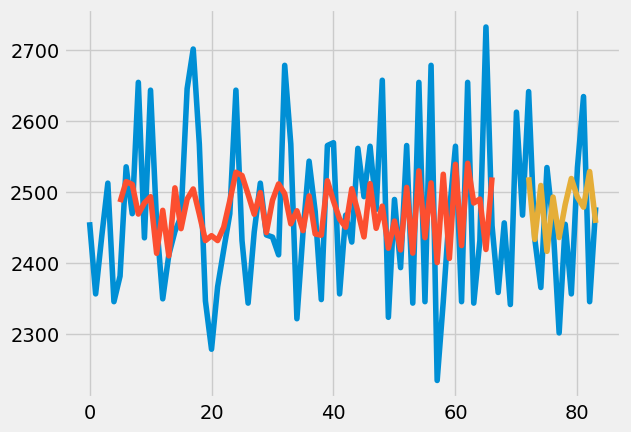

In [75]:
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict13)+seq_size, :] = trainPredict13

testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict13)+(seq_size*2):len(df), :] = testPredict13

plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [76]:
# Save Model
save_model = model13.save('model/model_vit.h5',save_format='h5')
save_model

In [77]:
testY_inverse.transpose()

array([[2641.],
       [2434.],
       [2365.],
       [2534.],
       [2453.],
       [2301.],
       [2454.],
       [2356.],
       [2534.],
       [2634.],
       [2345.],
       [2478.]])

In [78]:
testPredict13

array([[2520.331 ],
       [2432.712 ],
       [2508.7188],
       [2415.929 ],
       [2492.3977],
       [2435.428 ],
       [2482.038 ],
       [2518.5325],
       [2492.3164],
       [2478.2126],
       [2528.3599],
       [2455.9766]], dtype=float32)